In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import math
import os
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder

In [25]:
def read_files(path, name1, name2, name3):
    df1 = pd.read_csv(os.path.join(path, name1))
    df2 = pd.read_csv(os.path.join(path, name2))
    df3 = pd.read_csv(os.path.join(path, name3))
    return df1, df2, df3

def merge_dataset(df1, df2, df3):
    new_df = pd.merge(df1,  
                     df2,  
                     on ='building_id',  
                     how ='left')
    new_df = pd.merge(new_df,  
                     df3,  
                     on =['site_id', 'timestamp'],  
                     how ='left')
    return new_df

def cleaning_buildingDS(df):
    df = df.drop(["year_built", "floor_count"], axis=1)
    return df

def avg(df_col):
    meanval=statistics.mean(df_col.tolist())
    return meanval
def cleaning_weatherDS(df):
    df['dew_temperature'] = df['dew_temperature'].interpolate(method="linear", limit=5, limit_area="inside")
    df['air_temperature'] = df['air_temperature'].interpolate(method="linear", limit=5, limit_area="inside")
    df['cloud_coverage'] = df['cloud_coverage'].interpolate(method="linear", limit=5, limit_area="inside")
    sea_level_filler = df.groupby(['site_id'])['sea_level_pressure'].mean()
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])
    df.update(sea_level_filler,overwrite=False)
    #df['sea_level_pressure'].fillna(avg(df['sea_level_pressure']), inplace = True)
    return df
def transform_wind_dir(df: pd.DataFrame, column_name: str):
    df['wind_dir_sin']=np.sin(df[column_name])
    df['wind_dir_cos']=np.cos(df[column_name])
    return df
def drop_nan(df):
    df=df.dropna()
    return df
def timestamp_extraction(df):
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['dayofmonth'] = df['timestamp'].dt.day
    return df
def timestamp_conversion(df):
    df['hour_sin'] = np.sin(df['hour'])
    df['hour_cos'] = np.cos(df['hour'])
    df['dayofweek_sin'] = np.sin(df['dayofweek'])
    df['dayofweek_cos'] = np.cos(df['dayofweek'])
    df['month_sin'] = np.sin(df['month'])
    df['month_cos'] = np.cos(df['month'])
    df['dayofmonth_sin'] = np.sin(df['dayofmonth'])
    df['dayofmonth_cos'] = np.cos(df['dayofmonth'])
    return df
def one_hot_encode(df):
    categorical_column_names = ['site_id']
    for column_name in categorical_column_names:
        one_hot = pd.get_dummies(df[column_name])
        df = df.join(one_hot)

    df = df.drop(categorical_column_names, axis=1)
    return df

In [3]:
path='C:/Users/Viktor/Untitled Folder/Data/'
name1='building_metadata.csv'
name2='weather_train.csv'
name3='train.csv'
building_metadata, weather_train, train = read_files(path, name1, name2, name3)

In [4]:
building_metadata.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [5]:
weather_train.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [6]:
weather_train = cleaning_weatherDS(weather_train)

In [7]:
type(weather_train)

pandas.core.frame.DataFrame

In [8]:
weather_train = transform_wind_dir(weather_train, 'wind_direction')

In [9]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,wind_dir_sin,wind_dir_cos
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0.000000,1.000000
1,0,2016-01-01 01:00:00,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5,0.773891,0.633319
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,0.000000,1.000000
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,0.000000,1.000000
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,-0.970528,0.240988


In [10]:
train_all=merge_dataset(train, building_metadata, weather_train)

In [11]:
train_all.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,wind_dir_sin,wind_dir_cos
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0.0,1.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0.0,1.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0.0,1.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0.0,1.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0.0,1.0


In [12]:
train_all['meter_reading'].describe()

count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [13]:
# filtering outliers i.e data points 3 standard deviations away
train_all = train_all[train_all['meter_reading'] < 50000]

In [14]:
# electricity meter reading shouldn't be 0, filtering out all those rows
train_all = train_all[~((train_all['meter_reading'] == 0) & (train_all['meter'] == 0))]

In [15]:
train_all = timestamp_extraction(train_all)

In [16]:
train_all.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,wind_dir_sin,wind_dir_cos,hour,dayofweek,month,dayofmonth
45,46,0,2016-01-01,53.2397,0,Retail,9045,2016.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0.000000,1.000000,0,4,1,1
72,74,0,2016-01-01,43.0013,0,Parking,387638,1997.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0.000000,1.000000,0,4,1,1
91,93,0,2016-01-01,52.4206,0,Office,33370,1982.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0.000000,1.000000,0,4,1,1
103,105,0,2016-01-01,23.3036,1,Education,50623,NaN,5.0,3.8,...,NaN,1020.9,240.0,3.1,0.945445,0.325781,0,4,1,1
104,106,0,2016-01-01,0.3746,1,Education,5374,NaN,4.0,3.8,...,NaN,1020.9,240.0,3.1,0.945445,0.325781,0,4,1,1


Text(0.5, 1.0, 'Percentage share of building types')

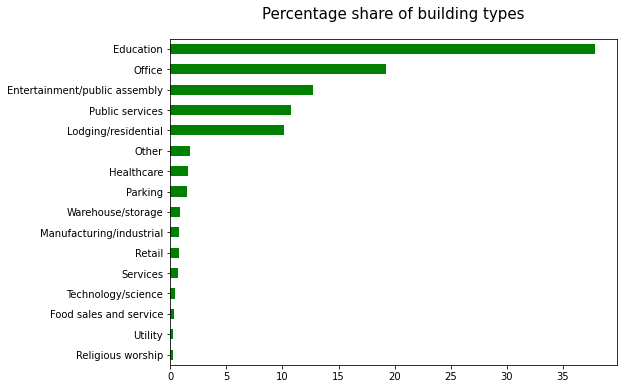

In [17]:
plt.figure(figsize=(8,6))
temp_df = (building_metadata['primary_use'].value_counts(normalize = True)*100).sort_values()
temp_df.plot(kind = 'barh', color = 'green')
plt.title('Percentage share of building types', pad = 20, fontsize = 15)

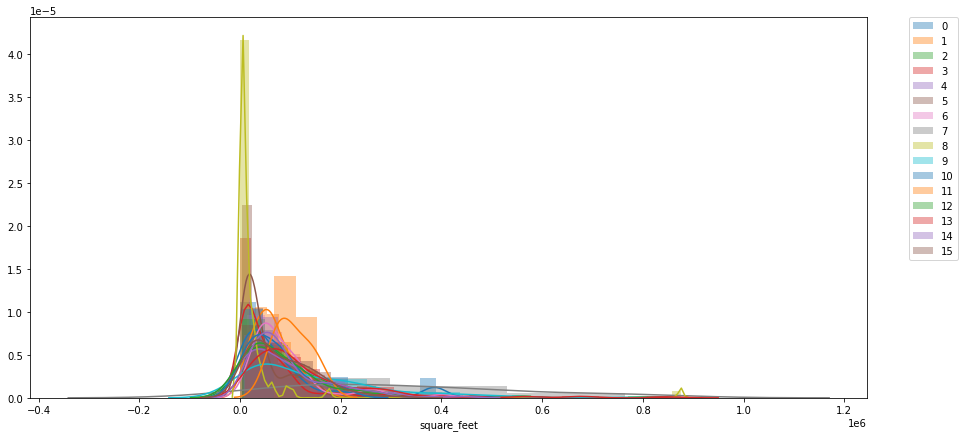

In [18]:
plt.figure(figsize=(15,7))
for i in range(0,16):
    build_met=building_metadata[building_metadata['site_id']==i]
    sns.distplot(build_met['square_feet'],label=i)
    i=i+1
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

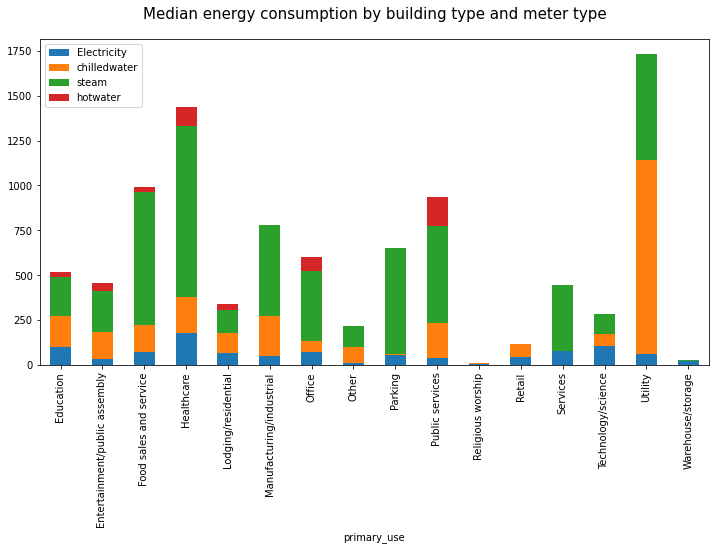

In [19]:
train_all.groupby(['primary_use', 'meter'])['meter_reading'].median().unstack().plot(kind = 'bar', stacked = True, figsize = (12,6))
plt.title('Median energy consumption by building type and meter type', fontsize = 15, pad = 20)
plt.legend(labels=['Electricity', 'chilledwater', 'steam', 'hotwater'])

Text(0, 0.5, 'Number of buildings')

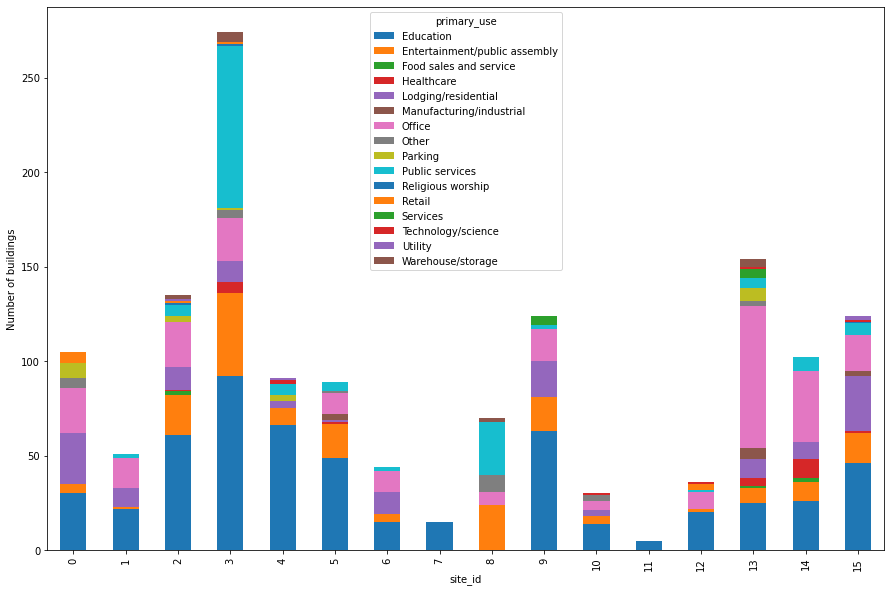

In [20]:
pd.crosstab(index=building_metadata['site_id'],columns=building_metadata['primary_use'], dropna=True).plot(kind='bar', stacked=True, figsize=(15,10))
plt.ylabel('Number of buildings')

Text(0.5, 1.0, 'Hourly distribution of energy consumption')

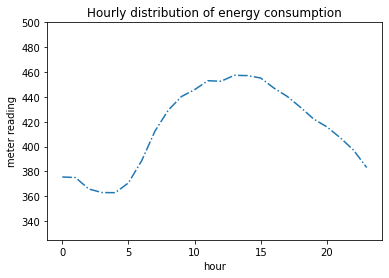

In [21]:
# higher consumption during day
train_all.groupby('hour')['meter_reading'].mean().plot(linestyle='-.').axes.set_ylim(325,500)
plt.ylabel('meter reading')
plt.title('Hourly distribution of energy consumption')

Text(0.5, 1.0, 'Weekly distribution of energy consumption')

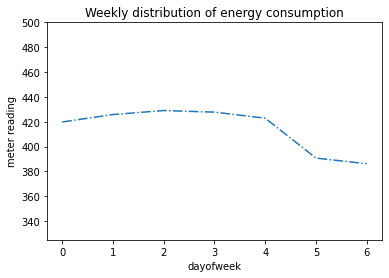

In [22]:
# higher consumption during weekdays
train_all.groupby('dayofweek')['meter_reading'].mean().plot(linestyle='-.').axes.set_ylim(325,500)
plt.ylabel('meter reading')
plt.title('Weekly distribution of energy consumption')

Text(0.5, 1.0, 'Impact of Air Temperature on Power Consumption')

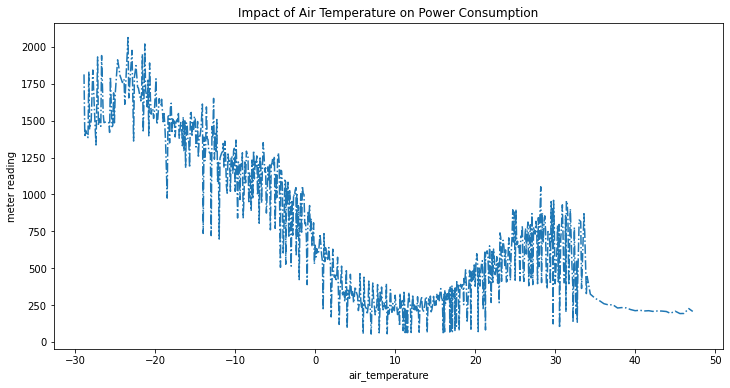

In [23]:
# a clear trend, pleasant temperature results in lower consumption
plt.figure(figsize=(12,6))
train_all.groupby('air_temperature')['meter_reading'].mean().plot(linestyle='-.')
plt.ylabel('meter reading')
plt.title('Impact of Air Temperature on Power Consumption')

In [24]:
train_all = one_hot_encode(train_all)
train_all = train_all.drop(['timestamp', 'building_id'], axis=1)
train_all.head()

,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,...,Office,Other,Parking,Public services,Religious worship,Retail,Services,Technology/science,Utility,Warehouse/storage
45,0,53.2397,0,9045,2016.0,NaN,25.0,6.0,20.0,NaN,...,0,0,0,0,0,1,0,0,0,0
72,0,43.0013,0,387638,1997.0,NaN,25.0,6.0,20.0,NaN,...,0,0,1,0,0,0,0,0,0,0
91,0,52.4206,0,33370,1982.0,NaN,25.0,6.0,20.0,NaN,...,1,0,0,0,0,0,0,0,0,0
103,0,23.3036,1,50623,NaN,5.0,3.8,NaN,2.4,NaN,...,0,0,0,0,0,0,0,0,0,0
104,0,0.3746,1,5374,NaN,4.0,3.8,NaN,2.4,NaN,...,0,0,0,0,0,0,0,0,0,0


In [28]:
train_all.head()

,meter,meter_reading,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,...,6,7,8,9,10,11,12,13,14,15
45,0,53.2397,9045,2016.0,NaN,25.0,6.0,20.0,NaN,1019.7,...,0,0,0,0,0,0,0,0,0,0
72,0,43.0013,387638,1997.0,NaN,25.0,6.0,20.0,NaN,1019.7,...,0,0,0,0,0,0,0,0,0,0
91,0,52.4206,33370,1982.0,NaN,25.0,6.0,20.0,NaN,1019.7,...,0,0,0,0,0,0,0,0,0,0
103,0,23.3036,50623,NaN,5.0,3.8,NaN,2.4,NaN,1020.9,...,0,0,0,0,0,0,0,0,0,0
104,0,0.3746,5374,NaN,4.0,3.8,NaN,2.4,NaN,1020.9,...,0,0,0,0,0,0,0,0,0,0


In [29]:
train_all = train_all.drop(["year_built", "floor_count", 'precip_depth_1_hr'], axis=1)
train_all = drop_nan(train_all)

,meter,meter_reading,square_feet,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed,wind_dir_sin,...,6,7,8,9,10,11,12,13,14,15
45,0,53.2397,9045,25.0,6.0,20.0,1019.7,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
72,0,43.0013,387638,25.0,6.0,20.0,1019.7,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
91,0,52.4206,33370,25.0,6.0,20.0,1019.7,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
166,0,114.7100,43681,15.6,6.0,-5.6,1015.3,270.0,3.6,-0.176046,...,0,0,0,0,0,0,0,0,0,0
167,0,28.1000,5258,15.6,6.0,-5.6,1015.3,270.0,3.6,-0.176046,...,0,0,0,0,0,0,0,0,0,0


In [31]:
train_all.info

<bound method DataFrame.info of           meter  meter_reading  square_feet  air_temperature  cloud_coverage  \
45            0        53.2397         9045             25.0             6.0   
72            0        43.0013       387638             25.0             6.0   
91            0        52.4206        33370             25.0             6.0   
166           0       114.7100        43681             15.6             6.0   
167           0        28.1000         5258             15.6             6.0   
...         ...            ...          ...              ...             ...   
20215846      1         0.0000        87200              6.1             4.0   
20215847      3      1909.3300        87200              6.1             4.0   
20215848      0        14.0000        84688              6.1             4.0   
20215849      1         0.0000        84688              6.1             4.0   
20215850      3       364.0190        84688              6.1             4.0   

       